<a href="https://colab.research.google.com/github/morrowbord/Spark/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Custom_Transformer_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark==2.4.0

     |████████████████████████████████| 213.4 MB 15 kB/s 
     |████████████████████████████████| 197 kB 63.1 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.0-py2.py3-none-any.whl size=213793605 sha256=723c43ede3e2440b7fbb047dff867d762373653725a569461bd00733806e0e1c
  Stored in directory: /root/.cache/pip/wheels/16/f1/95/5f30ebf85b300509e4dbce37d94daf7af58269db2e3af17b47
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.2
    Uninstalling py4j-0.10.9.2:
      Successfully uninstalled py4j-0.10.9.2
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.2.0
    Uninstalling pyspark-3.2.0:
      Successfully uninstalled pyspark-3.2.0


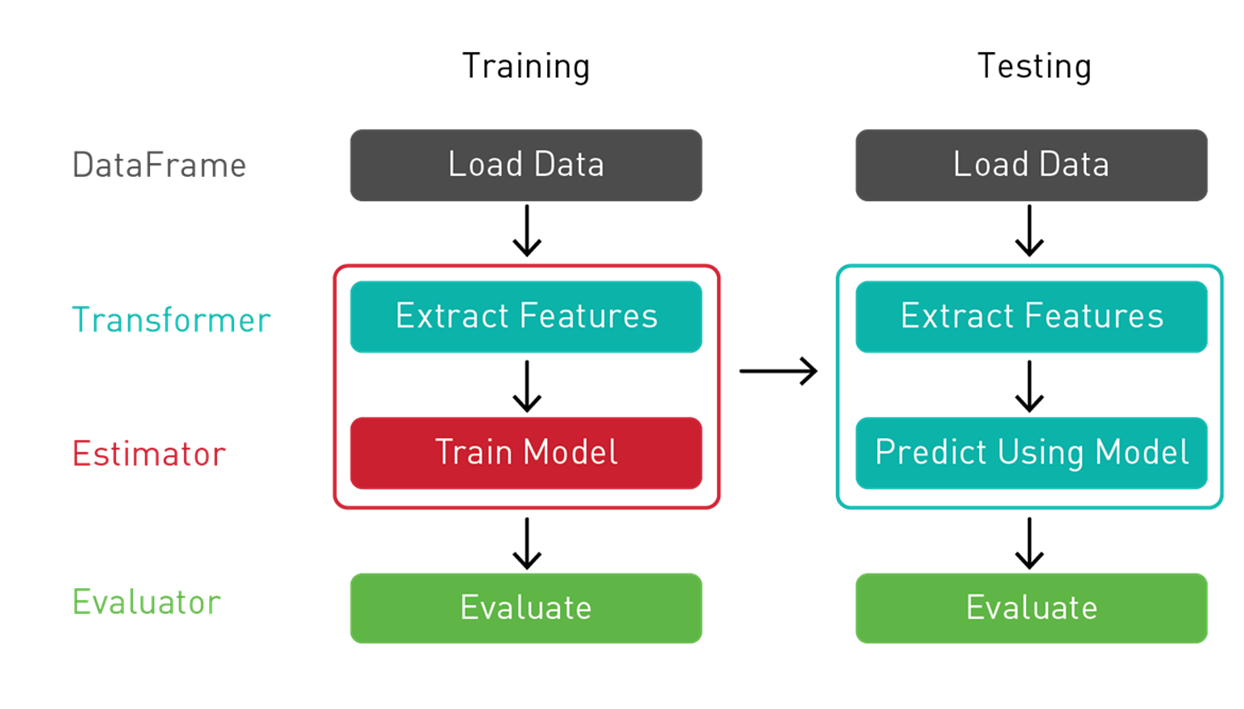

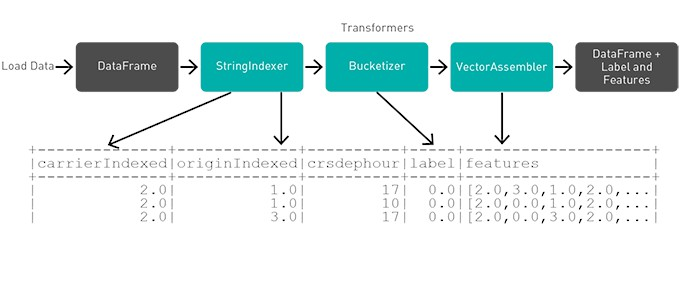

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .master("local[2]")\
    .appName("Transformers")\
    .config("spark.executor.instances", 2)\
    .config("spark.executor.memory", '2g')\
    .config("spark.executor.cores", 1)\
    .config("spark.executor.cores", 1)\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()
sc = spark.sparkContext

In [ ]:
spark

# Transformers

[Transformer base class](https://github.com/apache/spark/blob/v2.4.0/python/pyspark/ml/base.py#L139)

[Estimator base class](https://github.com/apache/spark/blob/v2.4.0/python/pyspark/ml/base.py#L70)

## Создадим базовый трансформатор

In [ ]:
from pyspark.ml import Transformer
import pyspark.sql.functions as F

In [ ]:
class ConstTransformer(Transformer):
    """Constant transformer.
    
    It just adds one constant column with a predefined name
    """
    def _transform(self, dataset):
        return dataset.withColumn("mytransformer", F.lit("I am a constant!"))

In [ ]:
df = spark.range(10)

In [ ]:
df.show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [ ]:
transformer = ConstTransformer()

In [ ]:
transformer.transform(df).show()

+---+----------------+
| id|   mytransformer|
+---+----------------+
|  0|I am a constant!|
|  1|I am a constant!|
|  2|I am a constant!|
|  3|I am a constant!|
|  4|I am a constant!|
|  5|I am a constant!|
|  6|I am a constant!|
|  7|I am a constant!|
|  8|I am a constant!|
|  9|I am a constant!|
+---+----------------+



## Как специфицируются параметры transformer'а?

[HasOutputCol mixin](https://github.com/apache/spark/blob/v2.4.0/python/pyspark/ml/param/shared.py#L235)

In [ ]:
from pyspark.ml.param.shared import HasOutputCol, HasInputCol, Param,Params, TypeConverters
from pyspark.ml import UnaryTransformer

In [ ]:
class ConstTransformer(Transformer, HasInputCol, HasOutputCol):
    
    outputCol = Param(Params._dummy(), "outputCol", "output column name.", typeConverter=TypeConverters.toString)
    inputCol = Param(Params._dummy(), "inputCol", "output column name.", typeConverter=TypeConverters.toString)
    value1 = Param(Params._dummy(), "value1", "output column name.", typeConverter=TypeConverters.toString)

    """Constant transformer with variable name."""
    def __init__(self, inputCol=None, outputCol=None, value1='value'): 
        super(ConstTransformer, self).__init__()
        if self.outputCol is not None:
            self._set(outputCol=outputCol)
        if self.inputCol is not None:
            self._set(inputCol=inputCol)
        self._set(value1=value1)
                    
    def _transform(self, dataset):
        return dataset.withColumn('col', F.lit("value"))

In [ ]:
transformer = ConstTransformer('b')

TypeError: ignored

In [ ]:
transformer.setOutputCol('assf')

ConstTransformer_38f3883703ac

In [ ]:
transformer.transform(df).show()

+---+---------------+
| id|           assf|
+---+---------------+
|  0|I am a constant|
|  1|I am a constant|
|  2|I am a constant|
|  3|I am a constant|
|  4|I am a constant|
|  5|I am a constant|
|  6|I am a constant|
|  7|I am a constant|
|  8|I am a constant|
|  9|I am a constant|
+---+---------------+



In [ ]:
df.show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [ ]:
from pyspark import keyword_only

In [ ]:
class ConstTransformer(Transformer, HasOutputCol):
    @keyword_only
    def __init__(self, outputCol=None): 
        super(ConstTransformer, self).__init__()
        if outputCol is not None:
            self._setDefault(outputCol=outputCol)
        
    def _transform(self, dataset):
        return dataset.withColumn(self.getOutputCol(), F.lit("I am a constant"))

## Давайте создадим transformer с заданными input и output колонками?
[HasInputCol mixin](https://github.com/apache/spark/blob/v2.4.0/python/pyspark/ml/param/shared.py#L189)

In [ ]:
from pyspark.ml.param.shared import HasInputCol

In [ ]:
class HashTransformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(HashTransformer, self).__init__()
        if inputCol is not None:
            self._setDefault(inputCol=inputCol)
        if outputCol is not None:
            self._setDefault(outputCol=outputCol)
            
    def _transform(self, dataset):
        return dataset.withColumn(self.getOutputCol(), F.md5(F.col(self.getInputCol()).cast("string")))

## Как определить кастомный параметр?
[Param](https://github.com/apache/spark/blob/v2.4.0/python/pyspark/ml/param/__init__.py#L37)

In [ ]:
from pyspark.ml.param import Param, Params, TypeConverters

In [ ]:
class HashTransformer(Transformer, HasInputCol, HasOutputCol):
    
    algorithm = Param(Params._dummy(), "algorithm",
                      "hash function to use, must be one of (md5|sha1)",
                      typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, algorithm="md5"):
        super(HashTransformer, self).__init__()
        if inputCol is not None:
            self._setDefault(inputCol=inputCol)
        if outputCol is not None:
            self._setDefault(outputCol=outputCol)
        self._set(algorithm=algorithm)
        
    def get_hash_function(self):
        try:
            return getattr(F, self.getOrDefault("algorithm"))
        except AttributeError as e:
            raise ValueError("Unsupported algorithm {}".format(self.getOrDefault("algorithm")))
            
    def setAlgorithm(self, algorithm):
        self._set(algorithm=algorithm)
            
    def _transform(self, dataset):
        hash_col = self.get_hash_function()
        return dataset.withColumn(self.getOutputCol(), hash_col(F.col(self.getInputCol()).cast("string")))

##  Передадим параметр из одного Transformer'а в другой

In [ ]:
HashTransformer().explainParams()

'algorithm: hash function to use, must be one of (md5|sha1) (current: md5)\ninputCol: input column name. (undefined)\noutputCol: output column name. (default: HashTransformer_d4c9eef1e6ef__output)'

In [ ]:
class HashTransformer(Transformer, HasInputCol, HasOutputCol):
    
    algorithm = Param(Params._dummy(), "algorithm",
                      "hash function to use, must be one of (md5|sha1)",
                      typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, algorithm="md5"):
        super(HashTransformer, self).__init__()
        if inputCol is not None:
            self._setDefault(inputCol=inputCol)
        if outputCol is not None:
            self._setDefault(outputCol=outputCol)
        self._set(algorithm=algorithm)
        
    def get_hash_function(self):
        try:
            return getattr(F, self.getOrDefault("algorithm"))
        except AttributeError as e:
            raise ValueError("Unsupported algorithm {}".format(self.getOrDefault("algorithm")))
            
    def setAlgorithm(self, algorithm):
        self._set(algorithm=algorithm)
    
    def getAlgorithm(self):
        return self.getOrDefault("algorithm")

    def _transform(self, dataset):
        hash_col = self.get_hash_function()
        res = dataset.withColumn(self.getOutputCol(), hash_col(F.col(self.getInputCol()).cast("string")))
        self._set(algorithm='md5')
        return res

# Estimators

In [ ]:
from pyspark.ml import Estimator
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from pyspark.ml.linalg import DenseVector
from pyspark.sql.types import *
from pyspark.ml.linalg import VectorUDT

import pyspark.sql.functions as F

In [ ]:
X, y = make_classification(random_state=5757)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5757)
est = LogisticRegression(random_state=5757)
est.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5757, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
schema = StructType(fields=[
    StructField("features", VectorUDT()),
    StructField("label", IntegerType())
])

df_test = spark.createDataFrame(zip(map(DenseVector, X_test), map(int, y_test)), schema=schema)

In [ ]:
df_test.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.16713128673558...|    0|
|[2.50158633810562...|    0|
|[-0.7699917522248...|    0|
|[-0.9514898817744...|    0|
|[1.32598926517448...|    0|
|[-0.5091954518113...|    0|
|[-0.9442948966018...|    1|
|[0.53537784380006...|    1|
|[-1.9316295195085...|    0|
|[-0.8788162423442...|    1|
|[0.47792785291472...|    1|
|[-0.7537969085613...|    1|
|[-0.1103342853056...|    0|
|[0.21903394455633...|    1|
|[-0.7010314631582...|    1|
|[-0.4024860125426...|    1|
|[1.91508615582208...|    1|
|[1.03957987692160...|    1|
|[-1.9962336859493...|    1|
|[0.03293939843484...|    1|
+--------------------+-----+



In [ ]:
est_broadcast = spark.sparkContext.broadcast(est)

In [ ]:
@F.pandas_udf(FloatType())
def predict(series):
    predictions = est_broadcast.value.predict(series.tolist())
    return pd.Series(predictions)

In [ ]:
spark.stop()